Implement and thoroughly understand LSTMs (Including RNNs)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Chapter 10 - Deep learning with Python (second edition)

In [2]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [3]:
# # unzip this data file
# !unzip jena_climate_2009_2016.csv.zip

In [4]:
fname = os.path.join("jena_climate_2009_2016.csv")
fname

'jena_climate_2009_2016.csv'

In [5]:
with open(fname) as f:
    data = f.read()

In [6]:
lines = data.split("\n")

In [7]:
type(lines)

list

In [8]:
len(lines)

420452

In [9]:
header = lines[0].split(",")

In [10]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [11]:
lines = lines[1:]

In [12]:
print(len(lines))

420451


In [13]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

In [14]:
print(temperature.shape), print(raw_data.shape)

(420451,)
(420451, 14)


(None, None)

In [15]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [16]:
# Here, the temperature is just an array of the temperature variable, and raw_data consists of all variables including the temperature, but not the date

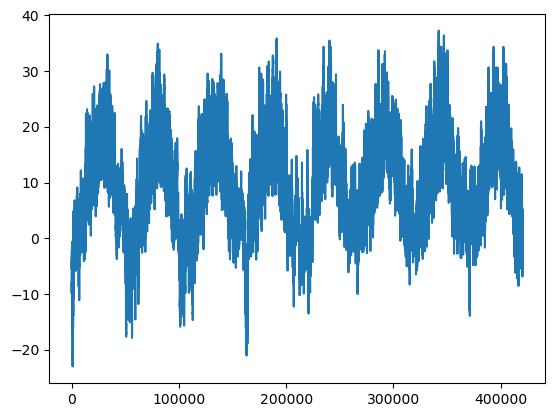

In [17]:
# plot the timeseries of temperature
plt.plot(range(len(temperature)), temperature)
plt.show()

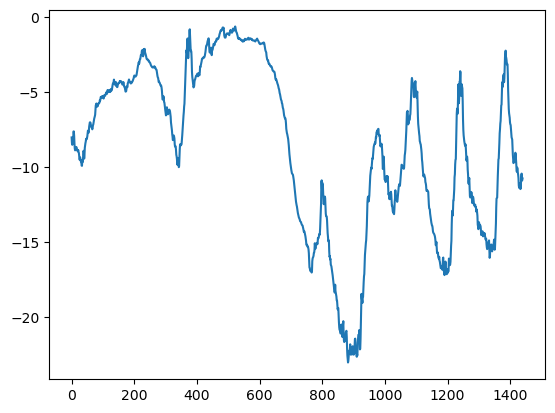

In [18]:
# plot just a selected range of temperatures - 10 days - note the dataset is for 10-minutes temperatures collected daily.
# (why 1440? for one day, we will have 24*6 = 144 readings, therefore 1440 in 10 days)

plt.plot(range(1440), temperature[:1440])
plt.show()

In [19]:
24*6

144

In [20]:
# Preparing the train data

# Number of samples for each split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [21]:
# normalize the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [43]:
# mean and std for the temperature variable
mean[1], std[1]

(8.825903294089702, 8.770983608349871)

In [22]:
# using timeseries_dataset_from_array() in keras
int_sequence = np.arange(10)
# dummy_dataset below is a dataset object
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

In [23]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [24]:
# Using this method to preprocess data to fit a machine learning model

# Goal: Forecast the temperature after 24 hours from the current time period

# sampling rate would mean we are samplig every 6th position - basically just consider 1 value for every hour (eventhough the datset has 6 as obseravtions are recorded every 10 minutes)
sampling_rate = 6
# sequence length menas to consider the previous 5 days (24*5 = 120)
sequence_length = 120
# delay would tell which observation will be the target for each observation sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
# batch size how many observations to process at once -  do not overthink this, this is similar to batch size in DL models.
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [38]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


##### Fitting some models

Naive model

In [41]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [44]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    aaaa = samples
    bbbb = targets
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A baseline ML model - a simple dense network

In [67]:
# define the model

inputs = tf.keras.Input(shape = (sequence_length, raw_data.shape[-1]))
# notice the input is flattened as the Dense network only takes 2D features as inputs (or you can reshape here)
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(16, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 1680)              0         
                                                                 
 dense_3 (Dense)             (None, 16)                26896     
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [68]:
# add early stopping
Es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', restore_best_weights = True, verbose = 1, patience = 5)

In [69]:
# compile model
model.compile(optimizer = "rmsprop", loss = 'mse', metrics = ["mae"])

In [70]:
# fit the model
history = model.fit(train_dataset, epochs = 50, validation_data = val_dataset, callbacks = [Es])

Epoch 1/50
819/819 [==============================] - 5s 6ms/step - loss: 19.6667 - mae: 3.3868 - val_loss: 12.6491 - val_mae: 2.8201
Epoch 2/50
819/819 [==============================] - 4s 5ms/step - loss: 10.9355 - mae: 2.6060 - val_loss: 12.0802 - val_mae: 2.7487
Epoch 3/50
819/819 [==============================] - 4s 5ms/step - loss: 10.0640 - mae: 2.4938 - val_loss: 13.2601 - val_mae: 2.8680
Epoch 4/50
819/819 [==============================] - 4s 5ms/step - loss: 9.5099 - mae: 2.4228 - val_loss: 13.0200 - val_mae: 2.8822
Epoch 5/50
819/819 [==============================] - 4s 5ms/step - loss: 9.0328 - mae: 2.3594 - val_loss: 11.5516 - val_mae: 2.6941
Epoch 6/50
819/819 [==============================] - 4s 5ms/step - loss: 8.6289 - mae: 2.3079 - val_loss: 10.5343 - val_mae: 2.5822
Epoch 7/50
819/819 [==============================] - 4s 5ms/step - loss: 8.3072 - mae: 2.2678 - val_loss: 11.5117 - val_mae: 2.6869
Epoch 8/50
819/819 [==============================] - 4s 5ms/step 

In [71]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 1s 3ms/step - loss: 11.4085 - mae: 2.6607
Test MAE: 2.66


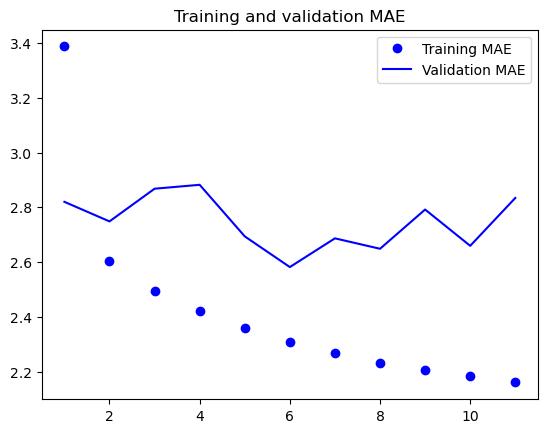

In [72]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

A Conv1D model

In [74]:
input_conv1d = tf.keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x_cov1d = tf.keras.layers.Conv1D(8, 24, activation = 'relu')(input_conv1d)
x_cov1d = tf.keras.layers.MaxPooling1D(2)(x_cov1d)
x_cov1d = tf.keras.layers.Conv1D(8, 12, activation = 'relu')(x_cov1d)
x_cov1d = tf.keras.layers.MaxPooling1D(2)(x_cov1d)
x_cov1d = tf.keras.layers.Conv1D(8, 6, activation = 'relu')(x_cov1d)
x_cov1d = tf.keras.layers.GlobalAveragePooling1D()(x_cov1d)
output_conv1d = tf.keras.layers.Dense(1)(x_cov1d)

model_con1D = tf.keras.Model(input_conv1d, output_conv1d)

model_con1D.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 97, 8)             2696      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 48, 8)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 8)             392 

In [77]:
# add early stopping
Es_conv1d = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, restore_best_weights = True)

In [78]:
# compile the model
model_con1D.compile(optimizer = "rmsprop", loss = "mse", metrics = ['mae'])

In [80]:
# fit the model
history_con1D = model_con1D.fit(train_dataset, epochs = 50, validation_data = val_dataset, callbacks = [Es_conv1d])

Epoch 1/50
819/819 [==============================] - 29s 6ms/step - loss: 21.2275 - mae: 3.6129 - val_loss: 15.4033 - val_mae: 3.1076
Epoch 2/50
819/819 [==============================] - 4s 5ms/step - loss: 15.2821 - mae: 3.1052 - val_loss: 14.7136 - val_mae: 3.0234
Epoch 3/50
819/819 [==============================] - 4s 5ms/step - loss: 14.0365 - mae: 2.9717 - val_loss: 15.2169 - val_mae: 3.0884
Epoch 4/50
819/819 [==============================] - 4s 5ms/step - loss: 13.1841 - mae: 2.8758 - val_loss: 16.6582 - val_mae: 3.2146
Epoch 5/50
819/819 [==============================] - 4s 5ms/step - loss: 12.4879 - mae: 2.7954 - val_loss: 15.8537 - val_mae: 3.1603
Epoch 6/50
819/819 [==============================] - 4s 5ms/step - loss: 11.9834 - mae: 2.7398 - val_loss: 14.7386 - val_mae: 3.0326
Epoch 7/50
819/819 [==============================] - 4s 5ms/step - loss: 11.6026 - mae: 2.6945 - val_loss: 16.3005 - val_mae: 3.2153
Epoch 7: early stopping


In [81]:
print(f"Test MAE: {model_con1D.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 2s 4ms/step - loss: 16.3780 - mae: 3.1882
Test MAE: 3.19


An LSTM model

In [89]:
inputs_lstm = tf.keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x_lstm = tf.keras.layers.LSTM(16)(inputs_lstm)
outputs_lstm = tf.keras.layers.Dense(1)(x_lstm)

lstm_model = tf.keras.Model(inputs_lstm, outputs_lstm)

lstm_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [90]:
# define early stopping
Es_lstm = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5, restore_best_weights = True)

In [91]:
# compile the model
lstm_model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

In [92]:
lstm_model.fit(train_dataset, epochs = 50, validation_data = val_dataset, callbacks = [Es_lstm])

Epoch 1/50
819/819 [==============================] - 8s 9ms/step - loss: 43.4543 - mae: 4.7895 - val_loss: 12.9815 - val_mae: 2.7443
Epoch 2/50
819/819 [==============================] - 6s 8ms/step - loss: 11.0476 - mae: 2.5809 - val_loss: 9.9772 - val_mae: 2.4661
Epoch 3/50
819/819 [==============================] - 6s 8ms/step - loss: 9.9271 - mae: 2.4573 - val_loss: 9.6973 - val_mae: 2.4292
Epoch 4/50
819/819 [==============================] - 6s 8ms/step - loss: 9.5500 - mae: 2.4061 - val_loss: 9.5023 - val_mae: 2.4020
Epoch 5/50
819/819 [==============================] - 6s 8ms/step - loss: 9.2551 - mae: 2.3658 - val_loss: 9.4979 - val_mae: 2.3966
Epoch 6/50
819/819 [==============================] - 6s 8ms/step - loss: 8.9899 - mae: 2.3324 - val_loss: 9.5746 - val_mae: 2.4065
Epoch 7/50
819/819 [==============================] - 6s 8ms/step - loss: 8.7421 - mae: 2.2998 - val_loss: 9.7095 - val_mae: 2.4208
Epoch 8/50
819/819 [==============================] - 6s 8ms/step - loss:

In [93]:
print(f"Test MAE: {lstm_model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 2s 4ms/step - loss: 10.0918 - mae: 2.4814
Test MAE: 2.48


In [94]:
# Numpy implementation of a forward pass of a simple RNN
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [96]:
final_output_sequence.shape

(100, 64)

In [99]:
inputs.shape, W.shape, U.shape, b.shape

((100, 32), (64, 32), (64, 64), (64,))

In [100]:
input_t = inputs[1]

In [102]:
input_t.shape

(32,)

In [103]:
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

In [104]:
output_t.shape

(64,)

Understand the forward pass better for a simple RNN

In [1]:
# Consider a single observation (maybe a single review for sentiment analysis). Cosnider 100 timesteps and feature size of 32 at each time step.

# Also consider a hidden size of 64 (which is also the output size)

In [31]:
import numpy as np
import tensorflow as tf

In [3]:
# Define the input parameters
time_steps = 100
input_size = 32
hidden_size = 64  # you can choose any size for the hidden state

In [4]:
# Initialize the weights and biases
Wxh = np.random.randn(hidden_size, input_size) * 0.01  # Input to hidden weights
Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden weights
bh = np.zeros((hidden_size,))  # Hidden state bias

In [5]:
Wxh.shape, Whh.shape, bh.shape

((64, 32), (64, 64), (64,))

In [6]:
# Initialize the hidden state (starting at zeros)
h = np.zeros((hidden_size,))

In [7]:
h.shape

(64,)

In [8]:
# Input data (1 observation, 100 time steps, 32 features per time step)
x = np.random.randn(time_steps, input_size)  # Single observation with 100 time steps

In [9]:
x.shape

(100, 32)

In [10]:
# Forward pass
for t in range(time_steps):
    # Update the hidden state
    h = np.tanh(np.dot(Wxh, x[t]) + np.dot(Whh, h) + bh)  # tanh activation function for RNN
    # Optionally, compute the output (depending on your model architecture)
    # y = np.dot(Wyh, h)  # Where Wyh is the output weight matrix (not included here)

In [12]:
# Final hidden state `h` after processing all time steps
print("Final hidden state:", h.shape)

Final hidden state: (64,)


In [ ]:
# Now, adjust this code for 10 observations

In [13]:
# Define the input parameters
time_steps = 100  # Number of time steps per observation
input_size = 32   # Features per time step
hidden_size = 64  # Hidden state size
num_observations = 10  # Number of observations

# Initialize the weights and biases
Wxh = np.random.randn(hidden_size, input_size) * 0.01  # Input to hidden weights
Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden weights
bh = np.zeros((hidden_size,))  # Hidden state bias

# Initialize the hidden state for all observations (batch size)
h = np.zeros((num_observations, hidden_size))  # Shape (num_observations, hidden_size)

# Input data (10 observations, 100 time steps, 32 features per time step)
x = np.random.randn(num_observations, time_steps, input_size)  # Shape (num_observations, time_steps, input_size)

# Forward pass
for t in range(time_steps):
    # Update the hidden state for each observation
    h = np.tanh(np.dot(x[:, t, :], Wxh.T) + np.dot(h, Whh.T) + bh)  # Applying to each observation in the batch

# Final hidden states `h` after processing all time steps
print("Final hidden states for all observations:", h.shape)


Final hidden states for all observations: (10, 64)


In [14]:
t

99

In [22]:
interm = np.dot(x[:, t, :], Wxh.T)

In [23]:
interm.shape

(10, 64)

In [16]:
x[:, t, :].shape

(10, 32)

In [17]:
bh.shape

(64,)

In [26]:
interm_bh = interm + bh

In [27]:
interm_bh.shape

(10, 64)

In [29]:
# sanity check - to verify that bh gets added properly
for i in range(10):
    interm_val = interm[i] + bh
    print(np.mean(interm_val == interm_bh[i]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [30]:
16*(31)

496

In [32]:
# Define the simple rnn network in the book to verify the number of weights

In [33]:
num_features = 14
# note below we keep the time steps dimension as None, this helps with varying number of time steps
inputs_sRNN = tf.keras.Input(shape = (None, num_features))
outputs_sRNN = tf.keras.layers.SimpleRNN(16)(inputs_sRNN)
simple_RNN = tf.keras.Model(inputs_sRNN, outputs_sRNN)

simple_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 14)]        0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Assume 100 time points
num_features = 14
# note below we keep the time steps dimension as None, this helps with varying number of time steps
inputs_sRNN = tf.keras.Input(shape = (100, num_features))
outputs_sRNN = tf.keras.layers.SimpleRNN(16, return_sequences = False)(inputs_sRNN)
simple_RNN = tf.keras.Model(inputs_sRNN, outputs_sRNN)

simple_RNN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 14)]         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


In [38]:
outputs_sRNN.shape # return_sequences = False is the default, if true, shape would be [None, timesteps, 16], None here is the batch_size

TensorShape([None, 16])

In [39]:
# Assume 100 time points - with return_sequences = True
num_features = 14
# note below we keep the time steps dimension as None, this helps with varying number of time steps
inputs_sRNN = tf.keras.Input(shape = (100, num_features))
outputs_sRNN = tf.keras.layers.SimpleRNN(16, return_sequences = True)(inputs_sRNN)
simple_RNN = tf.keras.Model(inputs_sRNN, outputs_sRNN)

simple_RNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 14)]         0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100, 16)           496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


In [40]:
outputs_sRNN.shape

TensorShape([None, 100, 16])

In [44]:
# Assume 100 time points - with return_sequences = True
num_features = 14
# note below we keep the time steps dimension as None, this helps with varying number of time steps
inputs_sRNN_2 = tf.keras.Input(shape = (100, num_features))
outputs_sRNN_2_1 = tf.keras.layers.SimpleRNN(16, return_sequences = True)(inputs_sRNN_2)
outputs_sRNN_2_2 = tf.keras.layers.SimpleRNN(8, return_sequences = True)(outputs_sRNN_2_1)
pred_out = tf.keras.layers.Dense(1)(outputs_sRNN_2_2)
simple_RNN_2 = tf.keras.Model(inputs_sRNN_2, pred_out)

simple_RNN_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 14)]         0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100, 16)           496       
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 100, 8)            200       
                                                                 
 dense (Dense)               (None, 100, 1)            9         
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
